In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

## Định nghĩa dataloader

In [2]:
# Ô này tạm thời bỏ qua không quan tâm nhiều
class CMAPSSDataset(Dataset):
    def __init__(self, data, seq_len=30):
        self.data = data
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        seq = self.data[idx:idx + self.seq_len, :-1]
        target = self.data[idx + self.seq_len - 1, -1]
        return torch.tensor(seq, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)


In [3]:
# Trong pytorch, dữ liệu phải được đưa vào một đối tượng mà pytorch có thể tự động đọc, điều này không giống trong keras do cách
# hoạt động khác nhau của mỗi framework
# FD004Dataset sẽ là nơi làm việc này, và trong này cũng miêu tả cách dữ liệu được xử lý như thế nào luôn
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

class FD004Dataset(Dataset):
    def __init__(self, data, sequence_length=30):
        self.data = data # Truyền vào data frame đã được xử lý ở trên
        self.sequence_length = sequence_length # Chỉ định khung cho mỗi mẫu data, ta lấy 30 dòng để dự đoán cho dòng 30
        self.sequences = [] # Cứ mỗi lần lấy ra 30 dòng thì thêm nó vào đây
        self.targets = [] # Nhãn càn dự đoán là RUL của dòng cuối cùng được lấy ra
        
        grouped = data.groupby('ID Engine') 
        for _, group in grouped:        
            values = group.drop(['ID Engine', 'Cycle', 'Remaining RUL'], axis=1).values
            rul_values = group['Remaining RUL'].values
            
            for i in range(len(values) - sequence_length + 1):
                self.sequences.append(values[i:i + sequence_length]) 
                self.targets.append(rul_values[i + sequence_length - 1])
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return (
            torch.tensor(self.sequences[idx], dtype=torch.float32),
            torch.tensor(self.targets[idx], dtype=torch.float32),
        )


## Định nghĩa mô hình Transformer

In [4]:
# Xây dựng kiến trúc mô hình Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dim_feedforward, dropout):
        super(TransformerModel, self).__init__()
        self.input_embedding = nn.Linear(input_dim, d_model)
        self.positional_encoding = nn.Parameter(torch.zeros(1, 5000, d_model))
        self.transformer = nn.Transformer(
            d_model=d_model, 
            nhead=nhead, 
            num_encoder_layers=num_layers, 
            num_decoder_layers=num_layers,
            dim_feedforward=dim_feedforward, 
            dropout=dropout,
        )
        self.fc_out = nn.Linear(d_model, 1)
    
    def forward(self, src):
        src_emb = self.input_embedding(src) + self.positional_encoding[:, :src.size(1), :]
        src_emb = src_emb.permute(1, 0, 2)  # [seq_len, batch_size, d_model]
        transformer_out = self.transformer(src_emb, src_emb)
        output = self.fc_out(transformer_out[-1, :, :])  # Lấy giá trị cuối
        return output.squeeze(-1)


## Loading dataset and preprocessing

In [5]:
train_4 = "../data/train_FD004.txt"

In [6]:
index_names = ['ID Engine', 'Cycle']
setting_names = ['Setting 1', 'Setting 2', 'Setting 3']
sensor_names = ['Sensor {}'.format(i) for i in range(1, 22)]
column_names = index_names + setting_names + sensor_names

train_4 = pd.read_csv(train_4, sep=' ', header=None)
train_4.drop([26, 27], axis=1, inplace=True)
train_4.columns = column_names

train_4['Remaining RUL'] = ''
train_4.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670,
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552,
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213,
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176,
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754,


In [7]:
# remaining_rul = max_rul - cycle
max_cycle = train_4.groupby('ID Engine').count()
for idx in range(len(train_4)):
    train_4.loc[idx, 'Remaining RUL'] = max_cycle.loc[train_4.loc[idx, 'ID Engine'], 'Cycle']
train_4['Remaining RUL'] = train_4['Remaining RUL'] - train_4['Cycle']

In [8]:
# train_4 = train_4.drop(['Setting 1','Setting 2', 'Sensor 1', 'Setting 3','Sensor 5','Sensor 6', 'Sensor 10', 'Sensor 16', 'Sensor 18','Sensor 19'], axis=1)
train_4.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670,320
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552,319
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213,318
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176,317
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754,316


In [9]:
# Chuẩn hóa dữ liệu
df = train_4.copy()
scaled_columns = df.columns[2:]
scaler = MinMaxScaler()
df[scaled_columns] = scaler.fit_transform(df[scaled_columns])
df.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,0.999926,0.997625,1.0,0.000000,0.130347,0.272082,0.212586,0.000000,...,0.993111,0.550773,0.400540,0.0,0.288660,0.627907,1.0,0.015473,0.015881,0.590406
1,1,2,0.476147,0.831591,1.0,0.626985,0.647971,0.634407,0.511781,0.507937,...,0.992395,0.481761,0.351346,0.0,0.608247,0.864693,1.0,0.477968,0.481487,0.588561
2,1,3,0.999900,0.998694,1.0,0.000000,0.123646,0.271245,0.222481,0.000000,...,0.993056,0.531031,0.423787,0.0,0.278351,0.627907,1.0,0.010764,0.018932,0.586716
3,1,4,0.999810,0.997625,1.0,0.000000,0.121351,0.266168,0.224835,0.000000,...,0.993194,0.553707,0.401716,0.0,0.268041,0.627907,1.0,0.012782,0.018724,0.584871
4,1,5,0.595275,0.737173,0.0,0.238089,0.005691,0.033916,0.022025,0.293184,...,0.001405,0.048140,0.920536,0.0,0.030928,0.000000,0.0,0.130172,0.145560,0.583026


## Huấn luyện mô hình với sequence_length = 50, 50 epochs

In [11]:
# Đưa dataset vào dataloader
dataset = FD004Dataset(df, sequence_length=50)
# Chia tập train và val theo tỉ lệ 80:20
# Tức là dùng ngay 80% dữ liệu để train và 20% dữ liệu để validate và không dùng tập test
train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)


In [12]:
dataset.__len__()

49048

In [13]:
train_data.__len__()

39238

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 21 sensor and 3 setting => 24 columns (24 input_dim)
input_dim = 24
model = TransformerModel(input_dim=input_dim, d_model=64, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.1)
model = model.to(device)

# hàm mất mát được dùng là hàm MSELoss (Mean Squared Error Loss)
criterion = nn.MSELoss()
# Hàm tối ưu là hàm Adam
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training Loop (50 Epochs)
for epoch in range(50):
    model.train()
    train_loss = 0
    for batch in train_loader:
        seq, target = batch
        seq, target = seq.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(seq)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            seq, target = batch
            seq, target = seq.to(device), target.to(device)
            output = model(seq)
            loss = criterion(output, target)
            val_loss += loss.item()
    
    print(f"Epoch {epoch + 1}: Train Loss = {train_loss / len(train_loader)}, Val Loss = {val_loss / len(val_loader)}")

Epoch 1: Train Loss = 0.025857598387606644, Val Loss = 0.012378682741889252
Epoch 2: Train Loss = 0.014527654026338212, Val Loss = 0.011506902439222469
Epoch 3: Train Loss = 0.01256089020306404, Val Loss = 0.013050063246260443
Epoch 4: Train Loss = 0.012077063764388557, Val Loss = 0.011892985975739912
Epoch 5: Train Loss = 0.011510717771346237, Val Loss = 0.011415853858273173
Epoch 6: Train Loss = 0.011271406968329907, Val Loss = 0.010542385273306639
Epoch 7: Train Loss = 0.011248126055987608, Val Loss = 0.010764964046229756
Epoch 8: Train Loss = 0.01111994584006756, Val Loss = 0.010877047131499366
Epoch 9: Train Loss = 0.010973092090200327, Val Loss = 0.01166488065654321
Epoch 10: Train Loss = 0.010847862632095072, Val Loss = 0.010127777750194316
Epoch 11: Train Loss = 0.01063355075206058, Val Loss = 0.012018669870642623
Epoch 12: Train Loss = 0.010334105306960028, Val Loss = 0.009707733513241336
Epoch 13: Train Loss = 0.010133398625337062, Val Loss = 0.010423078633244195
Epoch 14: Tr

In [15]:
model.eval()
sample, _ = dataset[0]
sample = sample.unsqueeze(0).to(device)  
predicted_rul = model(sample)
print(f"Predicted RUL: {predicted_rul.item()}")

Predicted RUL: 0.41714537143707275


In [16]:
# Lấy một vài mẫu dữ liệu từ tập val_loader
samples, targets = next(iter(val_loader))  # Lấy một batch từ validation set
samples, targets = samples.to(device), targets.to(device)

# Dự đoán với model
model.eval()
with torch.no_grad():
    predictions = model(samples)  # [batch_size]

# Đưa kết quả về CPU để xử lý
samples = samples.cpu()
targets = targets.cpu()
predictions = predictions.cpu()

In [17]:
# Đảo chuẩn hóa dữ liệu
rul_min = scaler.data_min_[-1]
rul_max = scaler.data_max_[-1]

# Đưa predictions và targets về dạng thực tế
actual_predictions = predictions.numpy() * (rul_max - rul_min) + rul_min
actual_targets = targets.numpy() * (rul_max - rul_min) + rul_min


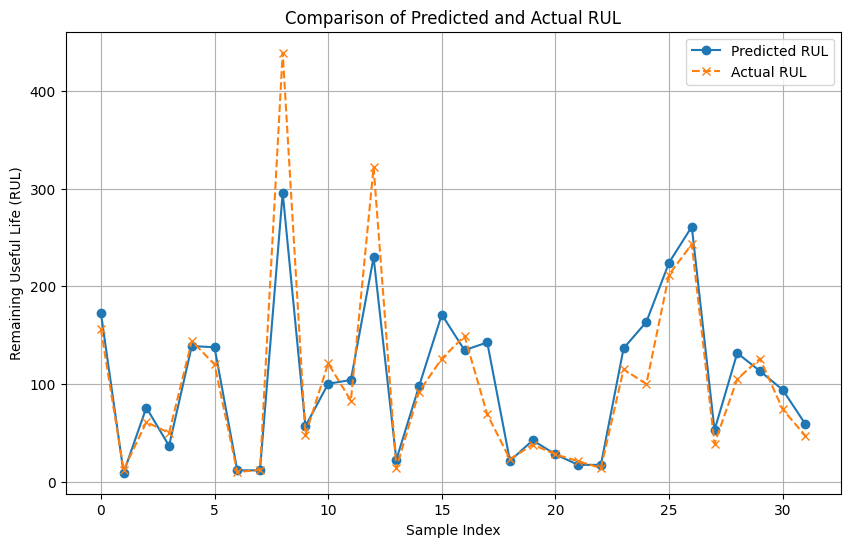

In [18]:
# Vẽ biểu đồ so sánh dự đoán và giá trị thực tế
plt.figure(figsize=(10, 6))
plt.plot(range(len(actual_predictions)), actual_predictions, label="Predicted RUL", marker='o', linestyle='-')
plt.plot(range(len(actual_targets)), actual_targets, label="Actual RUL", marker='x', linestyle='--')
plt.title("Comparison of Predicted and Actual RUL")
plt.xlabel("Sample Index")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend()
plt.grid(True)
plt.show()


## Huấn luyện mô hình với sequence_length = 10, 50 epochs

In [19]:
# Đưa dataset vào dataloader
dataset = FD004Dataset(df, sequence_length=10)
# Chia tập train và val theo tỉ lệ 80:20
# Tức là dùng ngay 80% dữ liệu để train và 20% dữ liệu để validate và không dùng tập test
train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Sau khi tiền xử lý data thì còn 17 cột (do bỏ đi các cột không cần thiết (sensor 1,5,6...))
# Loại bỏ đi cột  ID Engine, Cycle, Remaining RUL trong FD004Dataset, RUl là đầu ra nên cần bỏ đi, và không được đưa vào mô hình (ban đầu có 17 dim)
input_dim = 24
# Ngoài input_dim=14 ra, thì các tham số các này có thể thay đổi. các tham số còn lại có thể thay đổi tùy thuộc vào mô hình
model = TransformerModel(input_dim=input_dim, d_model=64, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.1)
model = model.to(device)

# hàm mất mát được dùng là hàm MSELoss (Mean Squared Error Loss)
criterion = nn.MSELoss()
# Hàm tối ưu là hàm Adam
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training Loop (50 Epochs)
for epoch in range(50):
    model.train()
    train_loss = 0
    for batch in train_loader:
        seq, target = batch
        seq, target = seq.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(seq)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            seq, target = batch
            seq, target = seq.to(device), target.to(device)
            output = model(seq)
            loss = criterion(output, target)
            val_loss += loss.item()
    
    print(f"Epoch {epoch + 1}: Train Loss = {train_loss / len(train_loader)}, Val Loss = {val_loss / len(val_loader)}")

Epoch 1: Train Loss = 0.02750867085694146, Val Loss = 0.013570870604709316
Epoch 2: Train Loss = 0.015470008132190552, Val Loss = 0.012707603597498642
Epoch 3: Train Loss = 0.013682412438228384, Val Loss = 0.011806427478426841
Epoch 4: Train Loss = 0.012899243420331934, Val Loss = 0.011580522485117763
Epoch 5: Train Loss = 0.012761104300486928, Val Loss = 0.011859542357061452
Epoch 6: Train Loss = 0.012453985742803129, Val Loss = 0.012151982379082823
Epoch 7: Train Loss = 0.012372877778956126, Val Loss = 0.011348741696920336
Epoch 8: Train Loss = 0.0121228213642527, Val Loss = 0.011610960957611884
Epoch 9: Train Loss = 0.01215040535987216, Val Loss = 0.011208215552990433
Epoch 10: Train Loss = 0.012042902727096485, Val Loss = 0.011366190478397499
Epoch 11: Train Loss = 0.011932027819604287, Val Loss = 0.01319770551056962
Epoch 12: Train Loss = 0.011989328612890196, Val Loss = 0.01112962814570382
Epoch 13: Train Loss = 0.01186740323383775, Val Loss = 0.011217107200682122
Epoch 14: Train

In [21]:
# Lấy một vài mẫu dữ liệu từ tập val_loader
samples, targets = next(iter(val_loader))  # Lấy một batch từ validation set
samples, targets = samples.to(device), targets.to(device)

# Dự đoán với model
model.eval()
with torch.no_grad():
    predictions = model(samples)  # [batch_size]

# Đưa kết quả về CPU để xử lý
samples = samples.cpu()
targets = targets.cpu()
predictions = predictions.cpu()

In [22]:
# Đảo chuẩn hóa dữ liệu
rul_min = scaler.data_min_[-1]
rul_max = scaler.data_max_[-1]

# Đưa predictions và targets về dạng thực tế
actual_predictions = predictions.numpy() * (rul_max - rul_min) + rul_min
actual_targets = targets.numpy() * (rul_max - rul_min) + rul_min


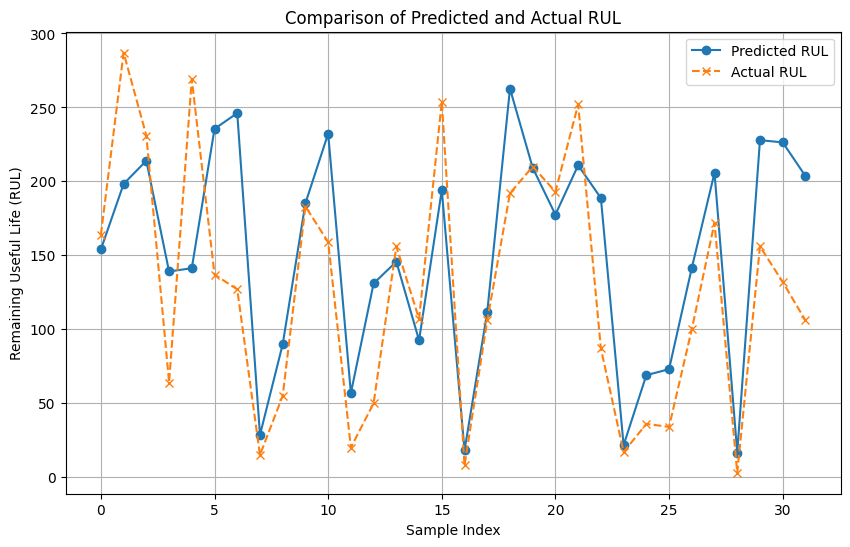

In [23]:
# Vẽ biểu đồ so sánh dự đoán và giá trị thực tế
plt.figure(figsize=(10, 6))
plt.plot(range(len(actual_predictions)), actual_predictions, label="Predicted RUL", marker='o', linestyle='-')
plt.plot(range(len(actual_targets)), actual_targets, label="Actual RUL", marker='x', linestyle='--')
plt.title("Comparison of Predicted and Actual RUL")
plt.xlabel("Sample Index")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend()
plt.grid(True)
plt.show()


## Huấn luyện mô hình với sequence_length = 30, 50 epochs

In [24]:
# Đưa dataset vào dataloader
dataset = FD004Dataset(df, sequence_length=30)
# Chia tập train và val theo tỉ lệ 80:20
# Tức là dùng ngay 80% dữ liệu để train và 20% dữ liệu để validate và không dùng tập test
train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)


In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Sau khi tiền xử lý data thì còn 17 cột (do bỏ đi các cột không cần thiết (sensor 1,5,6...))
# Loại bỏ đi cột  ID Engine, Cycle, Remaining RUL trong FD004Dataset, RUl là đầu ra nên cần bỏ đi, và không được đưa vào mô hình (ban đầu có 17 dim)
input_dim = 24
# Ngoài input_dim=14 ra, thì các tham số các này có thể thay đổi. các tham số còn lại có thể thay đổi tùy thuộc vào mô hình
model = TransformerModel(input_dim=input_dim, d_model=64, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.1)
model = model.to(device)

# hàm mất mát được dùng là hàm MSELoss (Mean Squared Error Loss)
criterion = nn.MSELoss()
# Hàm tối ưu là hàm Adam
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training Loop (50 Epochs)
for epoch in range(50):
    model.train()
    train_loss = 0
    for batch in train_loader:
        seq, target = batch
        seq, target = seq.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(seq)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            seq, target = batch
            seq, target = seq.to(device), target.to(device)
            output = model(seq)
            loss = criterion(output, target)
            val_loss += loss.item()
    
    print(f"Epoch {epoch + 1}: Train Loss = {train_loss / len(train_loader)}, Val Loss = {val_loss / len(val_loader)}")

Epoch 1: Train Loss = 0.023265356436126393, Val Loss = 0.013349015092113491
Epoch 2: Train Loss = 0.01360146966152759, Val Loss = 0.013264449116272422
Epoch 3: Train Loss = 0.012414094989396891, Val Loss = 0.01796652137483718
Epoch 4: Train Loss = 0.011920505349450558, Val Loss = 0.011540020109270011
Epoch 5: Train Loss = 0.011697272242920309, Val Loss = 0.010986678716974587
Epoch 6: Train Loss = 0.011485557113398421, Val Loss = 0.010852663137139918
Epoch 7: Train Loss = 0.011470164310912306, Val Loss = 0.011073347976012431
Epoch 8: Train Loss = 0.011418696914625104, Val Loss = 0.011186249103650627
Epoch 9: Train Loss = 0.011224778075402618, Val Loss = 0.010693751828684388
Epoch 10: Train Loss = 0.011144324287332369, Val Loss = 0.010677291458533229
Epoch 11: Train Loss = 0.010936649640826308, Val Loss = 0.010600145548008956
Epoch 12: Train Loss = 0.010912356408744455, Val Loss = 0.011424083845447418
Epoch 13: Train Loss = 0.010833487069567901, Val Loss = 0.01053397634449641
Epoch 14: T

In [26]:
# Lấy một vài mẫu dữ liệu từ tập val_loader
samples, targets = next(iter(val_loader))  # Lấy một batch từ validation set
samples, targets = samples.to(device), targets.to(device)

# Dự đoán với model
model.eval()
with torch.no_grad():
    predictions = model(samples)  # [batch_size]

# Đưa kết quả về CPU để xử lý
samples = samples.cpu()
targets = targets.cpu()
predictions = predictions.cpu()

In [27]:
# Đảo chuẩn hóa dữ liệu
rul_min = scaler.data_min_[-1]
rul_max = scaler.data_max_[-1]

# Đưa predictions và targets về dạng thực tế
actual_predictions = predictions.numpy() * (rul_max - rul_min) + rul_min
actual_targets = targets.numpy() * (rul_max - rul_min) + rul_min


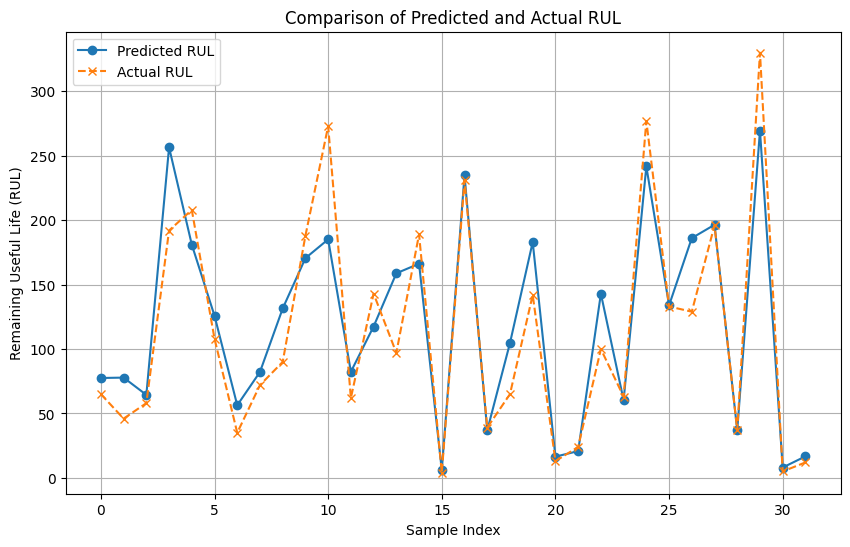

In [28]:
# Vẽ biểu đồ so sánh dự đoán và giá trị thực tế
plt.figure(figsize=(10, 6))
plt.plot(range(len(actual_predictions)), actual_predictions, label="Predicted RUL", marker='o', linestyle='-')
plt.plot(range(len(actual_targets)), actual_targets, label="Actual RUL", marker='x', linestyle='--')
plt.title("Comparison of Predicted and Actual RUL")
plt.xlabel("Sample Index")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend()
plt.grid(True)
plt.show()


##

In [29]:
# import shap 
# shap.__version__

In [30]:
# samples, targets = next(iter(val_loader))
# print(samples[1].__len__())

In [31]:
# # Define a wrapper to explain the Transformer model
# class TransformerWrapper:
#     def __init__(self, model):
#         self.model = model

#     def __call__(self, inputs):
#         # Convert inputs to tensor if not already
#         if not isinstance(inputs, torch.Tensor):
#             inputs = torch.tensor(inputs, dtype=torch.float32)
#         inputs = inputs.to(device)  # Send to the same device as the model
#         with torch.no_grad():
#             outputs = self.model(inputs)
#         return outputs.cpu().numpy()

In [32]:
# # Instantiate the wrapper
# explainer_model = TransformerWrapper(model)

# sample_data = samples[0]
# sample_data = sample_data.numpy()

# # Ensure sample_data and baseline have correct dimensions
# baseline = np.mean(sample_data, axis=0, keepdims=True)  # Mean across batch
# baseline = baseline[np.newaxis, :, :]  # Add batch dimension to ensure 3D shape: [1, seq_len, feature_dim]
# print(f'baseline shape = {baseline.shape}')

# # SHAP explainer (Kernel SHAP for simplicity)
# explainer = shap.KernelExplainer(explainer_model, baseline)

# # Generate SHAP values
# shap_values = explainer.shap_values(sample_data)
# print(f'shap values = {shap_values.shape}')

In [33]:
# print(f'shap values = {shap_values.shape}')
# shap.summary_plot(shap_values, sample_data)